# Process GESTALT barcodes from serially sampled sperm data 
##### Authors: 
###### Step A: Andy Sposato
###### Step B: Andy Sposato
###### Step C: Andy Sposato
###### Step D: Andy Sposato
###### Step E: Kimberly Truong & Andy Sposato
######
### A) Throw out whole files that have low total reads and write passed-samples-info.csv.
##### Files that pass this step are given the extension: .passReadCounts. 
##### The passed-samples-info.csv is generated using only the .passReadCounts files. This csv will be important for step E when making the barcode matrix. 
### B) Filter barcodes by reads and proportion cutoffs. 
##### Barcodes that pass this step are added to files given the extension: .filteredReadCounts.  
### C) Examine questionable barcodes and identify contaminant barcodes. 
##### To examine barcodes for each fish, a dictionary of barcodes was created for each fish. 
##### Fish dictionaries are written to files and stored in the "fish_dictionaries" folder which is at the same level as SpermAnalysis_Muller1. 
##### The list of questionable and good barcodes were written to files in the "fish_dictionaries" folder. 
### D) Remove contaminant barcodes from their read files. 
##### Barcodes that pass this step are added to files given the extension: .filteredQualityReadCounts.
### E) Make barcode matrix. 
##### A composite barcode matrix file containing barcode information for all fish in the dataset is written to the experiments folder and used for generating Muller plots.
##### Barcode matrix files for each individual fish are also written to the experiments folder.
## Warnings: 
##### Make sure this python notebook file is stored at the same level as "SpermAnalysis_Muller1".
##### This pipeline will break if you change your naming system for sample replicates or mess with the data structure Kimberly established. See github.com/Gagnon-lab/Sperm-Analysis for Kimberly's pipeline.

In [2]:
import datetime
import os 
import re
import operator
import collections
import numpy as np
import pandas as pd
from natsort import natsorted 
import matplotlib.pyplot as plt 

In [3]:
experiments_subfolder = "./SpermAnalysis_Muller1/experiments/" + datetime.datetime.today().strftime('%m.%d.%Y') + "_" + datetime.datetime.today().strftime('%I.%M_%p') + "/"
# if the experiments_subfolder doesn't already exist, create it
if not os.path.exists(experiments_subfolder): 
    os.mkdir(experiments_subfolder)

## A) Throw out whole files that have low total reads and write passed-samples-info.csv.

Currently, Kimberly's code relies on the user writing a samples-info.csv from scratch. We want to filter samples that are totally garbage (all barcodes have small numbers of reads). Then write a samples-info.csv based on the .allReadCounts files that remain after that step. We'll have to rewrite .allReadCounts we want to keep with a "pass" key in the name so that we can direct next steps to read just those files. Next steps include removing barcodes with low read numbers and proportions and removing contaminant barcodes from their samples. 

### Write .passedReadCounts files
###### These are .allReadCounts files that have at least 1000 total reads across all barcodes

#### Find all the .allReadCounts file paths in your data directory

In [4]:
# where are we in the directory?
print(os.getcwd())

/Users/andysposato/Desktop/process_sperm_barcodes


In [5]:
# get list of file paths leading to .allReadCounts files
filepaths = []
for dirpath, dirnames, filenames in os.walk("."):
   for filename in filenames:
      if filename.endswith(".allReadCounts"):
          filepath = os.path.join(dirpath, filename)
          filepaths.append(filepath)

filepaths = natsorted(filepaths)
print("An example .allReadCounts filepath in your directory: " + str(filepaths[0]))

An example .allReadCounts filepath in your directory: ./SpermAnalysis_Muller1/data/viz-Output/fish1_s3_rep1/fish1_s3_rep1.allReadCounts


#### Determine how many total reads are in each .allReadCounts file. 

In [6]:
# how many reads are in each .allReadCounts file? 
print("Printing...\n'path/to/.allReadCounts file': # reads in that .allReadCounts file:\n")
for read_file in filepaths: 
    file = open(read_file, "r")
    file.readline()
    read_count_sum = 0
    for lines in file.readlines(): 
        line = lines.split("\t")
        barcode = line[0]
        rank = line[1]
        reads = int(line[2])
        proportion = line[3]
        read_count_sum += reads
    print(read_file + ': ' + str(read_count_sum))
    file.close()      

Printing...
'path/to/.allReadCounts file': # reads in that .allReadCounts file:

./SpermAnalysis_Muller1/data/viz-Output/fish1_s3_rep1/fish1_s3_rep1.allReadCounts: 4737
./SpermAnalysis_Muller1/data/viz-Output/fish1_s3_rep2/fish1_s3_rep2.allReadCounts: 9463
./SpermAnalysis_Muller1/data/viz-Output/fish1_s3_rep3/fish1_s3_rep3.allReadCounts: 10116
./SpermAnalysis_Muller1/data/viz-Output/fish1_s4_rep1/fish1_s4_rep1.allReadCounts: 12421
./SpermAnalysis_Muller1/data/viz-Output/fish1_s4_rep2/fish1_s4_rep2.allReadCounts: 12655
./SpermAnalysis_Muller1/data/viz-Output/fish1_s4_rep3/fish1_s4_rep3.allReadCounts: 12381
./SpermAnalysis_Muller1/data/viz-Output/fish1_s5_rep1/fish1_s5_rep1.allReadCounts: 25412
./SpermAnalysis_Muller1/data/viz-Output/fish1_s5_rep2/fish1_s5_rep2.allReadCounts: 20158
./SpermAnalysis_Muller1/data/viz-Output/fish1_s5_rep3/fish1_s5_rep3.allReadCounts: 11275
./SpermAnalysis_Muller1/data/viz-Output/fish1_s6_rep1/fish1_s6_rep1.allReadCounts: 23533
./SpermAnalysis_Muller1/data/vi

#### Write the files

##### In this next cell, we're making a list of files we'll keep for analysis. Andy and Jenna arbitrarily picked 1000 to explore this. 

In [7]:
# assign an output directory, passed files should be in the same subfolder where allReadCounts files are
output_dir = "./SpermAnalysis_Muller1/data/viz-Output/"

# make an empty list that will hold the filepaths for allReadCount files we want to keep for analysis
keep_read_files = []
# for every path to an allReadCounts file
for read_file in filepaths: 
    # grab info from the filepath and store as variables to use later
    sample_id = read_file.split("/") # split file path by '/'
    sample_id = str(sample_id[-2]) # sample_id = full name of the sample (i.e. fishctrl3_s5_rep3)
    fish = sample_id.split("_")[0][4:] # fish is the fish identity (i.e. fish5)   
    # now count reads in file 
    # open file for reading
    file = open(read_file, "r") 
    # read the header
    file.readline() 
    # set sum of read counts to zero before we start counting
    read_count_sum = 0  
    # store contents of read file line as a list called lines
    lines = file.readlines() 
    # for each line in lines
    for line in lines: 
        line = line.split("\t") # split file path by tab character
        barcode = line[0] # barcode is first element
        rank = line[1] # rank is second element
        reads = int(line[2]) # make third element (reads) an integer
        proportion = line[3] # proportion is third element
        read_count_sum += reads # add the reads from that line to our read counter: read_count_sum
    # if read_count_sum is bigger than 1000 - change this number later based on histogram data
    total_read_cutoff = 999
    if read_count_sum > total_read_cutoff: 
        # add the file path to the keep_read_files list
        keep_read_files.append(read_file)
    # close the file
    file.close()

##### In this next cell, printing the list of files we're going to keep. This list can be checked with the results of the cell where we printed total reads in a file. 

In [8]:
# print file paths we're keeping
for filepath in keep_read_files: 
    print(filepath)

./SpermAnalysis_Muller1/data/viz-Output/fish1_s3_rep1/fish1_s3_rep1.allReadCounts
./SpermAnalysis_Muller1/data/viz-Output/fish1_s3_rep2/fish1_s3_rep2.allReadCounts
./SpermAnalysis_Muller1/data/viz-Output/fish1_s3_rep3/fish1_s3_rep3.allReadCounts
./SpermAnalysis_Muller1/data/viz-Output/fish1_s4_rep1/fish1_s4_rep1.allReadCounts
./SpermAnalysis_Muller1/data/viz-Output/fish1_s4_rep2/fish1_s4_rep2.allReadCounts
./SpermAnalysis_Muller1/data/viz-Output/fish1_s4_rep3/fish1_s4_rep3.allReadCounts
./SpermAnalysis_Muller1/data/viz-Output/fish1_s5_rep1/fish1_s5_rep1.allReadCounts
./SpermAnalysis_Muller1/data/viz-Output/fish1_s5_rep2/fish1_s5_rep2.allReadCounts
./SpermAnalysis_Muller1/data/viz-Output/fish1_s5_rep3/fish1_s5_rep3.allReadCounts
./SpermAnalysis_Muller1/data/viz-Output/fish1_s6_rep1/fish1_s6_rep1.allReadCounts
./SpermAnalysis_Muller1/data/viz-Output/fish1_s6_rep2/fish1_s6_rep2.allReadCounts
./SpermAnalysis_Muller1/data/viz-Output/fish1_s6_rep3/fish1_s6_rep3.allReadCounts
./SpermAnalysis_

##### Looks right. In this next cell, we're writing the keep files (a copy of .allReadCounts that pass total read filter - 1000).

In [9]:
for read_file in keep_read_files:
    # grab info and store as variables 
    sample_id = read_file.split("/")
    sample_id = str(sample_id[-2])
    fish = sample_id.split("_")[0][4:]
    # we're giving the copied files an extension name .passReadCounts so we can search for them later
    keep_file = open(output_dir+'/'+sample_id+'/' + sample_id + '.passReadCounts', 'w')
    file = open(read_file, "r")
    for line in file.readlines(): 
        keep_file.write(line)
    file.close()
    keep_file.close()

Excellent. Now we can see that, for example, fish1_s9_rep1 and rep3 have .passReadCounts files, but not fish1_s9_rep2 (as expected). 

### Now we automatically write the samples-info.csv file from .passReadCounts files
###### This file is used later when we write the barcode matrix file

In [10]:
# Jenna started sampling fish when they were 4 months old
start_age = 4

In [11]:
print(os.getcwd())

/Users/andysposato/Desktop/process_sperm_barcodes


#### Find all the .passReadCounts file paths in your data directory

In [12]:
filepaths = []
for dirpath, dirnames, filenames in os.walk("."):
   for filename in filenames:
      if filename.endswith(".passReadCounts"):
          filepath = os.path.join(dirpath, filename)
          filepaths.append(filepath)

filepaths = natsorted(filepaths)
print("An example .passReadCounts filepath in your directory: " + str(filepaths[0]))

An example .passReadCounts filepath in your directory: ./SpermAnalysis_Muller1/data/viz-Output/fish1_s3_rep1/fish1_s3_rep1.passReadCounts


#### Gather the information from the file name that will go into the contents of sample-info.csv and write it
###### We write the output file as "passed-samples-info.csv"

In [13]:
# from each file path, we want the sample_id (filename), fish id, age (sample+4), replicate, edited vs control
file = open("SpermAnalysis_Muller1/data/passed-samples-info.csv", "w")
file.write("sample_id,fish,age,replicate,condition\n")
for read_file in filepaths: 
    # grab info and store as variables 
    sample_id = read_file.split("/")
    sample_id = str(sample_id[-2])
    fish = sample_id.split("_")[0][4:]
    sample = sample_id.split("_")[1][1:]
    replicate = sample_id.split("_")[2][3:]
    age = str(int(sample) + start_age)
    if 'ctrl' in sample_id: 
        condition = 'control'
    else: 
        condition = 'edited'
    file.write(sample_id+','+fish+','+age+','+replicate+','+condition+'\n')
file.close()

### Step A summary report

In [14]:
allReadCounts_files = 0
passReadCounts_files = 0
passed_samples = []
failed_samples = []

# count files, add passing to passed_samples
for dirpath, dirnames, filenames in os.walk("."):
   for filename in filenames:
      if filename.endswith(".allReadCounts"):
          allReadCounts_files += 1 
      elif filename.endswith(".passReadCounts"):
          passReadCounts_files += 1
          sample_id = filename.split(".") # split file path by '.'
          sample_id = str(sample_id[0]) # sample_id = full name of the sample (i.e. fishctrl3_s5_rep3)
          passed_samples.append(sample_id)
        
# get list of filepaths leading to .allReadCounts files  
filepaths = []
for dirpath, dirnames, filenames in os.walk("."):
   for filename in filenames:
      if filename.endswith(".allReadCounts"):
          filepath = os.path.join(dirpath, filename)
          filepaths.append(filepath)

# get list of failed samples
for filename in filepaths:
    sample_id = filename.split("/") # split file path by '/'
    sample_id = str(sample_id[-2]) # sample_id = full name of the sample (i.e. fishctrl3_s5_rep3)
    if sample_id not in passed_samples: 
        failed_samples.append(sample_id)

In [15]:
summary = open(experiments_subfolder + "stepA_summary.txt", "w")
summary.write("Summary of step A: Throw out whole files that have low total reads and write passed-samples-info.csv.\n\n")
summary.write("Your data contains " + str(allReadCounts_files) + ' .allReadCounts files, or ' + str(allReadCounts_files) + ' samples including replicates.\n\n')
summary.write("If a file contained at least" + str(total_read_cutoff) + " total reads across all barcodes, then it has passed this filter step.\n") 
summary.write("\n")
if allReadCounts_files == passReadCounts_files: 
    summary.write("All of your files passed this step.\n")
elif allReadCounts_files < passReadCounts_files:
    summary.write("Something has gone wrong. You have more .passReadsCounts files than .allReadCounts files which should be impossible. Please check your data folders for duplicate read files.")
elif allReadCounts_files > passReadCounts_files:
    summary.write(str(allReadCounts_files-passReadCounts_files) + " files failed this step:\n")
    for read_file in filepaths: 
        #print(read_file)
        filename = read_file.split("/")
        sample_id = filename[-2]
        #print(filename)
        if sample_id in failed_samples: 
            file = open(read_file, "r")
            file.readline()
            read_count_sum = 0
            for lines in file.readlines(): 
                line = lines.split("\t")
                barcode = line[0]
                rank = line[1]
                reads = int(line[2])
                proportion = line[3]
                read_count_sum += reads
            summary.write(sample_id+ ' failed with only ' + str(read_count_sum) + ' total reads. \n')
        file.close()
summary.write("\n")
summary.write(str(passReadCounts_files) + " files passed the filter.\n\n")
summary.write("The contents of those passing files were copied to a new file with the extension name '.passReadCounts' \nin the same subfolder.\n\n")
summary.write("The passed-samples-info.csv was also written and saved to the folder called data.\nIt contains only samples that pass this step.\n")
summary.close() 

## B) Filter barcodes by reads and proportion cutoffs.

### Gather .passReadCounts files
###### These are .allReadCounts files that have at least 1000 total reads across all barcodes

In [16]:
filepaths = []
for dirpath, dirnames, filenames in os.walk("."):
   for filename in filenames:
      if filename.endswith(".passReadCounts"):
          filepath = os.path.join(dirpath, filename)
          filepaths.append(filepath)

filepaths = natsorted(filepaths)

In [17]:
# just making sure the file contents are what we expect 
print(filepaths[0])
file = open(filepaths[0], 'r')
file.readline()
print(file.readline())
file.close()

# should look something like this: 
#./SpermAnalysis_Muller1/data/viz-Output/fish1_s3_rep1/fish1_s3_rep1.passReadCounts
#1D+38_28D+41_NONE_NONE_NONE_NONE_NONE_NONE_NONE_NONE	0	2434	0.5138273168672155

./SpermAnalysis_Muller1/data/viz-Output/fish1_s3_rep1/fish1_s3_rep1.passReadCounts
1D+38_28D+41_NONE_NONE_NONE_NONE_NONE_NONE_NONE_NONE	0	2434	0.5138273168672155



### Write .filteredReadCounts files
###### These files will contain barcodes that have a minimum of 10 reads and a minimum proportion of 0.005.

In [18]:
filtered_output_dir = "./SpermAnalysis_Muller1/data/viz-Output"
# for every read file
for read_file in filepaths: 
    # grab sample and rep info and store as variables "fish_id_name" and "samp_rep"
    fish_id = read_file.split("/")
    fish_id = str(fish_id[-2])
    # open file for reading
    inputfile = open(read_file, "r")
    outputfile = open(filtered_output_dir+'/'+fish_id+'/' + fish_id + '.filteredReadCounts', 'w')
    outputfile.write('event' + '\t' + 'array' + '\t' + 'count' + '\t' + 'proportion' + '\n')
    # read the first line so we can ignore the headers in the loop
    inputfile.readline()
    # for each line containing a barcode in the allReadCounts file
    for lines in inputfile.readlines(): 
        # identify each element
        line = lines.split('\t')
        barcode = line[0]
        rank = line[1]
        reads = line[2]
        proportion = line[3]
        prop = proportion[0:-1]
        # if the barcode is found at a proportion of at least .005 and has at least 10 reads
        prop_cutoff = .005
        reads_cutoff = 10
        if float(prop) >= prop_cutoff and int(reads) >= reads_cutoff:
            outputfile.write(lines)
    outputfile.close()
    inputfile.close()

### Step B summary report

In [19]:
filtered_samples = []
# 
for dirpath, dirnames, filenames in os.walk("."):
   for filename in filenames:
      if filename.endswith(".filteredReadCounts"):
          sample_id = filename.split(".") # split file path by '.'
          sample_id = str(sample_id[0]) # sample_id = full name of the sample (i.e. fishctrl3_s5_rep3)
          filtered_samples.append(sample_id)
filtered_samples_sorted = natsorted(filtered_samples)

In [20]:
filepath_string = './SpermAnalysis_Muller1/data/viz-Output/' 
for sample_id in filtered_samples_sorted: 
    with open(filepath_string + sample_id + '/' + sample_id +'.filteredReadCounts', 'r') as filtered_file: 
        with open(filepath_string + sample_id + '/' + sample_id +'.passReadCounts', 'r') as pass_file:
            difference = set(pass_file).difference(filtered_file)
    difference.discard("\n")
    with open(filepath_string+sample_id+'/'+sample_id+'_'+'stepB_removed_barcodes.txt', 'w') as file_out: 
        file_out.write("event" + '\t' + "array" + '\t' + "count" +'\t' + "proportion" + '\n')
        for line in difference: 
            file_out.write(line)
    filtered_file.close()
    pass_file.close()
    file_out.close()

In [21]:
summary = open(experiments_subfolder + "stepB_summary.txt", 'w')
summary.write("Summary of step B: Filter barcodes by reads and proportion cutoffs.\n\n")
summary.write("For each .passReadCounts file, if a barcode had fewer than " + str(reads_cutoff) + " reads or a proportion below " + str(prop_cutoff) + ",\nit was removed from the file.\n\n")
summary.write("Passing barcodes for each sample were written to a sample file with the extension: .filteredReadCounts\n\n")
summary.write("A list of barcodes that were removed was written to a sample file that ends with 'stepB_removed_barcodes.txt'\nThis may be useful to verify that the changes from .passReadCounts to .filteredReadCounts were accurate.\n\n")
summary.write("Here is a recap of the filtering for each sample: \n\n") 
summary.write("**************************************************************************************** \n\n")

filepath_string = './SpermAnalysis_Muller1/data/viz-Output/' 

for sample_id in filtered_samples_sorted: 
    pass_read_counts = 0
    with open(filepath_string + sample_id + '/' + sample_id +'.passReadCounts', 'r') as pass_file:
        pass_file.readline()
        for lines in pass_file.readlines(): 
            line = lines.split("\t")
            barcode = line[0]
            rank = line[1]
            reads = int(line[2])
            proportion = line[3]
            pass_read_counts += reads
            pass_file.close()
    filtered_read_counts = 0
    with open(filepath_string + sample_id + '/' + sample_id +'.filteredReadCounts', 'r') as filtered_file: 
        filtered_file.readline()
        for lines in filtered_file.readlines(): 
            line = lines.split("\t")
            barcode = line[0]
            rank = line[1]
            reads = int(line[2])
            proportion = line[3]
            filtered_read_counts += reads
            filtered_file.close()
    reads_removed = pass_read_counts-filtered_read_counts
    summary.write(sample_id + " had " + str(pass_read_counts) + " reads in the .passReadCounts file. Filtering removed " + str(reads_removed) + ' reads.\n')
    summary.write("There are now " + str(filtered_read_counts) + " reads in the " + sample_id + ".filteredReadCounts file.\n\n")
    
    filtered_count = 0
    with open(filepath_string + sample_id + '/' + sample_id +'.filteredReadCounts', 'r') as filtered_file:
        filtered_file.readline()
        for line in filtered_file.readlines(): 
            filtered_count += 1
    filtered_file.close()
    pass_count = 0
    with open(filepath_string + sample_id + '/' + sample_id +'.passReadCounts', 'r') as pass_file:
        pass_file.readline()
        for line in pass_file.readlines(): 
            pass_count += 1
    pass_file.close()
    barcodes_removed = pass_count-filtered_count
    summary.write(sample_id + " had " + str(pass_count) + " barcodes in the .passReadCounts file. Filtering removed " + str(barcodes_removed) + ' barcodes.\n')
    if filtered_count == 1: 
        summary.write("There is now " + str(filtered_count) + " barcode in the " + sample_id + ".filteredReadCounts file.\n\n")
    else:     
        summary.write("There are now " + str(filtered_count) + " barcodes in the " + sample_id + ".filteredReadCounts file.\n\n")
    summary.write("**************************************************************************************** \n\n")
summary.close()

## C) Examine questionable barcodes and identify contaminant barcodes. 

Questionable barcodes are barcodes that show up in multiple animals. They are likely contamination. We want to confidently remove them from samples where they do not belong. Before we can remove them from the appropriate files, we need to examine each according to the number of reads that support them in every fish. 

### Make fish dictionaries
###### These will store all barcodes and their sample occurence on a fish by fish basis. 

In [22]:
filepaths = []
for dirpath, dirnames, filenames in os.walk("."):
   for filename in filenames:
      if filename.endswith(".filteredReadCounts"):
          filepath = os.path.join(dirpath, filename)
          filepaths.append(filepath)
filepaths = natsorted(filepaths)

In [23]:
# just making sure the file contents are what we expect 
print(filepaths[0])
file = open(filepaths[0], 'r')
file.readline()
print(file.readline())
file.close()

# should look something like this: 
#./SpermAnalysis_Muller1/data/viz-Output/fish1_s3_rep1/fish1_s3_rep1.filteredReadCounts
#1D+38_28D+41_NONE_NONE_NONE_NONE_NONE_NONE_NONE_NONE	0	2434	0.5138273168672155

./SpermAnalysis_Muller1/data/viz-Output/fish1_s3_rep1/fish1_s3_rep1.filteredReadCounts
1D+38_28D+41_NONE_NONE_NONE_NONE_NONE_NONE_NONE_NONE	0	2434	0.5138273168672155



In [24]:
# make a dictionary to hold all fish dictionaries 
# make each fish start with an empty dictionary
fishes = {}
for path in filepaths: 
    path = path.split("/")
    filename = path[-2]
    fish = filename.split("_")
    fish_name = fish[0]
    if fish_name not in fishes:
        fishes[fish_name] = {}

In [25]:
# so we should see a key for each fish in your data with a starting value of an empty dictionary
# like: ('fish1', {})
for fish in fishes.items(): 
    print(fish)

('fish1', {})
('fish5', {})
('fish10', {})
('fishctrl3', {})


In [26]:
# for every read file
for read_file in filepaths: 
    # grab sample and rep info and store as variables "fish_id_name" and "samp_rep"
    fish_id = read_file.split("/")
    fish_id = fish_id[-2]
    fish_id = fish_id.split("_")
    fish_id_name = fish_id[0]
    sample_name = fish_id[1]
    sample = sample_name[1:]
    replicate = fish_id[2]
    rep_num = replicate[-1]
    samp_rep = sample+"."+rep_num
    # if the fish id name matches a dictionary name in fishes
    if fish_id_name in fishes:
        # then open file for reading 
        file = open(read_file, "r")
        # read the first line so we can ignore the headers in the loop
        file.readline()
        # for each line containing a barcode in the allReadCounts file
        for line in file.readlines(): 
            # identify each element
            line = line.split('\t')
            barcode = line[0]
            rank = line[1]
            reads = line[2]
            proportion = line[3]
            prop = proportion[0:-1]
            # if the barcode is not found as a key in the fish's dictionary
            if barcode not in fishes[fish_id_name].keys(): 
                # then add it as a new key and store the sample replicate information as the first item in a list for that barcode's value
                fishes[fish_id_name][barcode] = [samp_rep+':'+prop+':'+reads]
            # else if the barcode already exists as a key in the fish's directory
            else:
                # then just add this sample replicate information to the list 
                if samp_rep not in fishes[fish_id_name][barcode]: 
                    fishes[fish_id_name][barcode].append(samp_rep+':'+prop+':'+reads)
        file.close()

### Write fish dictionaries to files 
###### This is so they can be read easily in Excel or a Text program like Notepad++ or BBEdit.
###### This is also helpful so they don't need to be recreated several times downstream.

In [27]:
# if the fish_dictionaries folder doesn't already exist, create it
if not os.path.exists('./fish_dictionaries/'): 
    os.mkdir("./fish_dictionaries/")
output_dir = "./fish_dictionaries/"

In [28]:
# write a file for each fish dictionary 
# for every fish in the fishes dictionary
for fish in fishes.keys(): 
    # create an output tsv file
    with open(output_dir+fish+"_dictionary.tsv", 'w') as f: 
        # write a header on the first line
        f.write(fish +'\t' + 'barcode' + '\t' + 'sample'+ '\t' + 'proportion'+ '\t' + 'read count'+'\n')
        # for each line, write the barcode (i) and the sample reps it shows up in within that fish (j)
        for i,j in fishes[fish].items():
            f.write('\t' + i)
            f.write('\n')
            for sample_detection in j:
                samp_detect = sample_detection.split(":")
                sample = samp_detect[0]
                prop = samp_detect[1]
                reads = samp_detect[2]
                f.write('\t' + '\t' + sample + '\t' + prop + '\t' + reads + '\n')
    f.close()

In [29]:
# write all dictionaries to one file called "fishes_dictionaries"
with open(output_dir+"fishes_dictionaries.tsv", "w") as f: 
    # write a header on the first line
    f.write('fish' +'\t' + 'barcode' + '\t' + 'sample'+ '\t' + 'proportion'+ '\t' + 'read count'+'\n')
    for fish in fishes.keys():
        # for each line, write the barcode (i) and the sample reps it shows up in within that fish (j)
        f.write(fish)
        f.write('\n')
        for i,j in fishes[fish].items():
            f.write('\t' + i)
            f.write('\n')
            for sample_detection in j:
                samp_detect = sample_detection.split(":")
                sample = samp_detect[0]
                prop = samp_detect[1]
                reads = samp_detect[2]
                f.write('\t' + '\t' + sample + '\t' + prop + '\t' + reads + '\n')
f.close()

### Find questionable barcodes
###### These are barcodes that show up in multiple fish. 
###### A barcode will not be tagged questionable if it shows up in multiple samples or replicates of a single fish. 

In [30]:
filepaths = []
for dirpath, dirnames, filenames in os.walk("."):
   for filename in filenames:
      if filename.endswith("dictionary.tsv"):
          filepath = os.path.join(dirpath, filename)
          filepaths.append(filepath)
filepaths = natsorted(filepaths)

In [31]:
# make a list to hold all fish names
fish_list = []
for path in filepaths: 
    path = path.split("/")
    # file name should be the last element when separated by /
    filename = path[-1]
    fish = filename.split("_")
    # fish name should be the first element when filename is separated by _
    fish_name = fish[0]
    # add all fish names to fish list
    if fish_name not in fish_list:
        fish_list.append(fish_name)

In [32]:
# save the unedited barcode string as a variable
unedited = "NONE_NONE_NONE_NONE_NONE_NONE_NONE_NONE_NONE_NONE"

In [33]:
all_barcodes = []
good_barcodes = []
bad_barcodes = []
questionable_barcodes = []

# for all fish dictionary tsv files
for read_file in filepaths: 
    # open the file 
    file = open(read_file, 'r')
    # read the first line to grab the fish name
    fish = file.readline().split("\t")[0]
    # for the barcode and sample replicate occurrence in each line
    for line in file.readlines(): 
        line = line.split("\t")
        # grab the barcode 
        barcode = line[1]
        barcode = barcode[0:-1]
        # if the barcode is not the unedited barcode, compare it to barcodes from other fish
        if barcode != unedited: 
            # if the barcode is not in all barcodes, 
            if barcode not in all_barcodes: 
                # add it to all barcodes 
                all_barcodes.append(barcode)
            # but 
            else:
                # if it is already in all barcodes
                if barcode in all_barcodes:
                    # and not in bad barcodes yet
                    if barcode not in bad_barcodes: 
                        # add it to bad barcodes list
                        bad_barcodes.append(barcode)
                        # this should prevent bad barcodes from being added twice or more to the bad barcodes list
file.close()

# for every barcode in all barcodes
for barcode in all_barcodes: 
    # if it's not in bad barcodes
    if barcode not in bad_barcodes: 
        # it is a good barcode
        good_barcodes.append(barcode)

for barcode in bad_barcodes: 
    if barcode != '': 
        questionable_barcodes.append(barcode)

good_barcodes.append(unedited)
all_barcodes.append(unedited)

In [34]:
print("These barcodes are suspicious because they either occur 'naturally' in multiple animals or they are a contaminant barcode in some animals:")
for barcode in questionable_barcodes:
    print(barcode)

These barcodes are suspicious because they either occur 'naturally' in multiple animals or they are a contaminant barcode in some animals:
NONE_2D+62_NONE_NONE_NONE_87D+167_87D+167_87D+167_87D+167_NONE
1D+37_NONE_NONE_NONE_NONE_NONE_NONE_NONE_NONE_NONE
2D+36_81D+61_81D+61_81D+61_81D+61_NONE_NONE_NONE_NONE_NONE
NONE_NONE_NONE_NONE_NONE_81D+170_81D+170_81D+170_81D+170_NONE
3D+35_3D+64_NONE_81D+119_81D+119_81D+119_81D+119_NONE_1I+254+C_NONE
1D+38_28D+41_NONE_NONE_NONE_NONE_54D+199_54D+199_54D+199_NONE
NONE_NONE_NONE_NONE_NONE_87D+167_87D+167_87D+167_87D+167_NONE
82D+36_82D+36_82D+36_82D+36_NONE_NONE_NONE_NONE_NONE_NONE
2I+36+GA_NONE_NONE_15D+111_72D+130_72D+130_72D+130_NONE_3D+251_NONE
7D+36_NONE_NONE_NONE_NONE_NONE_61D+195_61D+195_61D+195_NONE
87D+36_87D+36_87D+36_87D+36_NONE_1D+172_NONE_NONE_NONE_NONE
17I+38+GTACATCGAGTGTATGC_28D+65_28D+65_NONE_NONE_NONE_54D+199_54D+199_54D+199_NONE
NONE_NONE_NONE_NONE_NONE_NONE_54D+199_54D+199_54D+199_NONE
4D+38_15D+65_NONE_54D+119_54D+119_54D+119_NONE

It is recommended that you write your list of questionable barcodes to a text file so that if you need to pause analysis you can simply reload the list later

In [35]:
# write questionable barcodes to a file
output = open(output_dir+'questionable_barcodes_list.txt', 'w')
for barcode in questionable_barcodes: 
    output.write(barcode)
    output.write("\n")
output.close()
# write good barcodes to a file
output = open(output_dir+'good_barcodes_list.txt', 'w')
for barcode in good_barcodes: 
    output.write(barcode)
    output.write("\n")
output.close()

In [36]:
# load in the questionable barcodes list, we will examine them
barcodes_to_examine = []
output_dir = "./fish_dictionaries/"
file = open(output_dir+'questionable_barcodes_list.txt', "r")
print("contents of 'questionable_barcodes_list.txt': ") 
for line in file:
    line = line.split("\n")
    barcode = line[0]
    #print(barcode)
    barcodes_to_examine.append(barcode)

contents of 'questionable_barcodes_list.txt': 


### Examine questionable barcodes for contamination status

##### Gather read information for each questionable barcode

In [37]:
# make a dictionary to hold all barcode dictionaries 
# make each barcode start with an empty dictionary
questionable_barcodes = {}
for barcode in barcodes_to_examine: 
        questionable_barcodes[barcode] = {}

In [38]:
filepaths = []
for dirpath, dirnames, filenames in os.walk("."):
   for filename in filenames:
      if filename.endswith(".filteredReadCounts"):
          filepath = os.path.join(dirpath, filename)
          filepaths.append(filepath)

filepaths = natsorted(filepaths)

In [39]:
for barcode in questionable_barcodes.keys(): 
    for read_file in filepaths: 
        # grab sample and rep info and store as variables "fish_id_name" and "samp_rep"
        fish_id = read_file.split("/")
        fish_id = fish_id[-2]
        fish_id = fish_id.split("_")
        fish_id_name = fish_id[0]
        if fish_id_name not in barcode: 
            questionable_barcodes[barcode][fish_id_name] = 0

In [40]:
print("number of questionable barcodes: " + str(len(questionable_barcodes)) + "\n")

number of questionable barcodes: 16



##### **ESSENTIAL STEP:** Without generating a questionable_barcodes dictionary that contains the read counts, you cannot hope proceed to part D. 

In [41]:
# count reads associated with each questionable barcode across all fish and assign to barcode
for read_file in filepaths:
    # grab sample and rep info and store as variables "fish_id_name" and "samp_rep"
    fish_id = read_file.split("/")
    fish_id = fish_id[-2]
    fish_id = fish_id.split("_")
    fish_id_name = fish_id[0]
    # then open file for reading 
    file = open(read_file, "r")
    # read the first line so we can ignore the headers in the loop
    file.readline()
    for line in file.readlines():
        # identify each element
        line = line.split('\t')
        barcode = line[0]
        rank = line[1]
        reads = int(line[2])
        for questionable_barcode in questionable_barcodes.keys(): 
            if questionable_barcode == barcode: 
                questionable_barcodes[questionable_barcode][fish_id_name] += reads

In [42]:
# read questionable_barcodes dictionary
for barcode in questionable_barcodes.keys():
    for dict in questionable_barcodes.values(): 
        print(barcode)
        for key,value in dict.items():
            print(str(key) + ": " + str(value))

NONE_2D+62_NONE_NONE_NONE_87D+167_87D+167_87D+167_87D+167_NONE
fish1: 272
fish5: 182735
fish10: 0
fishctrl3: 0
NONE_2D+62_NONE_NONE_NONE_87D+167_87D+167_87D+167_87D+167_NONE
fish1: 373
fish5: 335
fish10: 0
fishctrl3: 0
NONE_2D+62_NONE_NONE_NONE_87D+167_87D+167_87D+167_87D+167_NONE
fish1: 1184
fish5: 167060
fish10: 0
fishctrl3: 0
NONE_2D+62_NONE_NONE_NONE_87D+167_87D+167_87D+167_87D+167_NONE
fish1: 3922
fish5: 5587
fish10: 2372
fishctrl3: 2316
NONE_2D+62_NONE_NONE_NONE_87D+167_87D+167_87D+167_87D+167_NONE
fish1: 23500
fish5: 492
fish10: 0
fishctrl3: 197
NONE_2D+62_NONE_NONE_NONE_87D+167_87D+167_87D+167_87D+167_NONE
fish1: 336271
fish5: 766
fish10: 0
fishctrl3: 0
NONE_2D+62_NONE_NONE_NONE_87D+167_87D+167_87D+167_87D+167_NONE
fish1: 376
fish5: 5562
fish10: 0
fishctrl3: 0
NONE_2D+62_NONE_NONE_NONE_87D+167_87D+167_87D+167_87D+167_NONE
fish1: 888
fish5: 278
fish10: 0
fishctrl3: 0
NONE_2D+62_NONE_NONE_NONE_87D+167_87D+167_87D+167_87D+167_NONE
fish1: 541
fish5: 578
fish10: 0
fishctrl3: 522
NON

##### Calculate ratios of winners to all losers. 
###### You can skip this part and move on to Step 4 if you are not trying to explore the contamination data with a histogram and just want the list of questionable barcodes.

In [43]:
# make a new dictionary to hold just the read counts
questionable_barcode_library = {}
for barcode in questionable_barcodes.keys(): 
    questionable_barcode_library[barcode] = []
for questionable_barcode in questionable_barcodes.keys(): 
    for barcode in questionable_barcode_library.keys(): 
        if barcode == questionable_barcode: 
            questionable_barcode_library[barcode] = list(questionable_barcodes[questionable_barcode].values())

In [44]:
# sort read count lists
for read_count_list in questionable_barcode_library.values(): 
    read_count_list = read_count_list.sort(reverse = True)

In [45]:
first_v_losers_ratios = []
for read_count_list in questionable_barcode_library.values(): 
    first_place = float(read_count_list[0])
    losers = sum(read_count_list[1:])
    ratio = first_place/losers
    first_v_losers_ratios.append(ratio)

###### Histogram

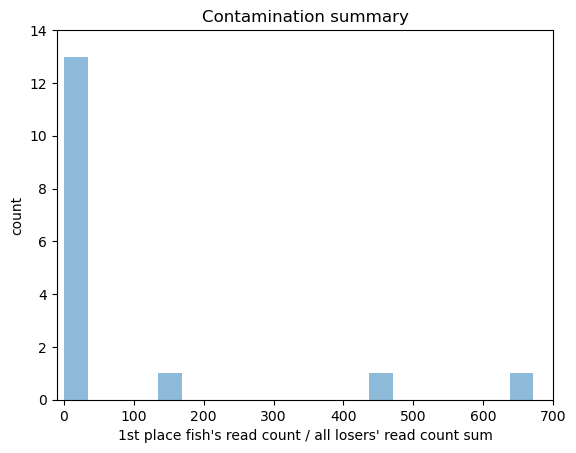

In [46]:
# plot histogram of winner ratios
# need to play with the axes to determine best values for your data
data = first_v_losers_ratios
bins = 20
plt.xlim([-10, 700])
plt.ylim([0, 14])
plt.hist(data, bins=bins, alpha=0.5)
plt.title('Contamination summary')
plt.xlabel("1st place fish's read count / all losers' read count sum")
plt.ylabel('count')
plt.show()

### Step C summary report

In [47]:
summary = open(experiments_subfolder+"stepC_summary.txt", 'w')
summary.write("Summary of step C: Examine questionable barcodes and identify contaminant barcodes.\n\n")
summary.write("A fish dictionary was created for each fish in your data and written to a file like fish1_dictionary.tsv \n\n")
summary.write("A dictionary holds every barcode found in any sample or replicate belonging to that animal.\n")
summary.write("For each barcode in that dictionary, information about:\n\t1) the sample replicate it showed up in,\n\t2) the proportion of that sample replicate's barcode population\n\t3) the number of reads associated with that barcode within the sample replicate\n")
summary.write("All dictionaries were also compiled into one file called fishes_dictionaries.tsv.\n\n")
summary.write("The fish dictionaries were used to compare barcode occurrence across fish.\nQuestionable barcodes are barcodes that show up in multiple fish.\nThis list was written to questionable_barcodes_list.txt.\n")
summary.write("\nThe rest of this step is exploring those questionable barcodes. The next set of filtered files\nare generated in Step D.\n")
summary.write("\nHere is an example fish dictionary: \n\n") 

dict_file = open("fish_dictionaries/fishctrl3_dictionary.tsv", "r")
for line in dict_file.readlines(): 
    summary.write(line)
dict_file.close()

summary.write("\n")
summary.close()

## D) Remove contaminant barcodes from read files.

The intent here is to remove barcodes that are contamination in just the fish where they don't belong. So for every questionable barcode, we want to categorize if it's a contaminant everywhere or has a source. 

### Sort questionable_barcodes dictionary
###### We want the fish with the highest number of reads to be listed last in the dictionary of each questionable barcode.

In [48]:
# sort the questionable_barcodes dictionary so that the fish are in ascending order according to reads
# save this as sorted_questionable_barcodes
sorted_questionable_barcodes = {}
for barcode, dictionary in questionable_barcodes.items(): 
    sorted_dictionary_values = sorted(dictionary.items(), key=operator.itemgetter(1))
    sorted_dictionary = collections.OrderedDict(sorted_dictionary_values)
    sorted_questionable_barcodes[barcode] = (sorted_dictionary)

### Associate each barcode with a contamination status
##### To determine a source fish, it must contain 199x more reads than the sum of all other fish.
###### Connor and Jenna are working on visualizing the read data for the whole data set. We'll alter this ratio cutoff later. 

In [49]:
# this dictionary will convert the reads information from sorted_questionable_barcodes into a qualitative dictionary called questionable_barcodes_summary
# in questionable_barcodes_summary, a barcode key will have a value that is either 'contaminant' or the source fish that barcode came from
questionable_barcodes_summary = {}
for barcode,dictionary in sorted_questionable_barcodes.items(): 
    dictionary = str(dictionary)[13:-3]
    dictionary_parts = dictionary.split("),")
    total_reads = 0
    read_count_list = []
    samples = []
    for part in dictionary_parts:
        info = part.split(", ")
        sample = info[0][1:]
        samples.append(sample)
        reads = int(info[1])
        read_count_list.append(reads)
        total_reads += int(info[1])
    winner = int(read_count_list[-1])
    losers_sum = total_reads-winner
    if winner == total_reads: 
        ratio = 1
    else: 
        ratio = winner/losers_sum
    # if the fish with the most reads has > 199x more reads than the rest of the fish, it is the source of that barcode
    if ratio > 199: 
        source = samples[-1][2:-1]
        questionable_barcodes_summary[barcode] = source
    # if not, the barcode is questionable everywhere and we call it contaminant
    else: 
        questionable_barcodes_summary[barcode] = 'contaminant'

In [50]:
questionable_barcodes_summary

{'NONE_2D+62_NONE_NONE_NONE_87D+167_87D+167_87D+167_87D+167_NONE': 'fish5',
 '1D+37_NONE_NONE_NONE_NONE_NONE_NONE_NONE_NONE_NONE': 'contaminant',
 '2D+36_81D+61_81D+61_81D+61_81D+61_NONE_NONE_NONE_NONE_NONE': 'contaminant',
 'NONE_NONE_NONE_NONE_NONE_81D+170_81D+170_81D+170_81D+170_NONE': 'contaminant',
 '3D+35_3D+64_NONE_81D+119_81D+119_81D+119_81D+119_NONE_1I+254+C_NONE': 'contaminant',
 '1D+38_28D+41_NONE_NONE_NONE_NONE_54D+199_54D+199_54D+199_NONE': 'fish1',
 'NONE_NONE_NONE_NONE_NONE_87D+167_87D+167_87D+167_87D+167_NONE': 'contaminant',
 '82D+36_82D+36_82D+36_82D+36_NONE_NONE_NONE_NONE_NONE_NONE': 'contaminant',
 '2I+36+GA_NONE_NONE_15D+111_72D+130_72D+130_72D+130_NONE_3D+251_NONE': 'contaminant',
 '7D+36_NONE_NONE_NONE_NONE_NONE_61D+195_61D+195_61D+195_NONE': 'contaminant',
 '87D+36_87D+36_87D+36_87D+36_NONE_1D+172_NONE_NONE_NONE_NONE': 'contaminant',
 '17I+38+GTACATCGAGTGTATGC_28D+65_28D+65_NONE_NONE_NONE_54D+199_54D+199_54D+199_NONE': 'contaminant',
 'NONE_NONE_NONE_NONE_NONE_N

### Remove contaminant barcodes from .filteredReadCount files
##### This will rewrite all of our .filteredReadCounts files as .filteredQualityReadCounts
###### Contaminant barcodes without a clear source are removed everywhere.
###### Contaminant barcodes with a clear source are removed everywhere except files belonging to the source fish.

In [51]:
filepaths = []
for dirpath, dirnames, filenames in os.walk("."):
   for filename in filenames:
      if filename.endswith(".filteredReadCounts"):
          filepath = os.path.join(dirpath, filename)
          filepaths.append(filepath)

filepaths = natsorted(filepaths)

In [52]:
filtered_output_dir = "./SpermAnalysis_Muller1/data/viz-Output"
for read_file in filepaths: 
    # grab sample and rep info and store as variables "fish_id_name" and "samp_rep"
    fish_id = read_file.split("/")
    fish_id = str(fish_id[-2])
    fish = fish_id.split("_")
    fish = fish[0]
    # open file for reading
    inputfile = open(read_file, "r")
    outputfile = open(filtered_output_dir+'/'+fish_id+'/' + fish_id + '.filteredQualityReadCounts', 'w')
    outputfile.write('event' + '\t' + 'array' + '\t' + 'count' + '\t' + 'proportion' + '\n')
    # read the first line so we can ignore headers
    inputfile.readline()
    for lines in inputfile.readlines(): 
    # identify each element
        line = lines.split('\t')
        barcode = line[0]
        rank = line[1]
        reads = line[2]
        proportion = line[3]
        prop = proportion[0:-1]
        # if the barcode is not questionable, then just copy the line exactly to the new file
        if barcode not in questionable_barcodes_summary.keys(): 
            outputfile.write(lines) 
        else: 
            # but if it is questionable,
            if barcode in questionable_barcodes_summary.keys(): 
                # copy to the new file only if the source fish exactly matches the fish name from this file
                if questionable_barcodes_summary[barcode] == fish: 
                    outputfile.write(lines)
    outputfile.close()
    inputfile.close()

The .filteredQualityReadCounts is written to the same subfolder where the original .allReadCounts file, .passReadCounts file and .filteredReadCounts file are. The .filteredQualityReadCounts should be used as the input in the make barcode matrix code. 

### Step D summary report

In [53]:
filtered_quality_samples = []
for dirpath, dirnames, filenames in os.walk("."):
   for filename in filenames:
      if filename.endswith(".filteredQualityReadCounts"):
          sample_id = filename.split(".") # split file path by '.'
          sample_id = str(sample_id[0]) # sample_id = full name of the sample (i.e. fishctrl3_s5_rep3)
          filtered_quality_samples.append(sample_id)
filtered_quality_samples_sorted = natsorted(filtered_quality_samples)

In [54]:
summary = open(experiments_subfolder+"stepD_summary.txt", 'w')
summary.write("Summary of step D: Remove contaminant barcodes from their read files.\n\n")
summary.write("The barcodes in questionable barcodes list were examined carefully for their presence across animals.\n")
summary.write("If a clear source of that barcode could be found, the questionable barcode was assigned a source fish.\n")
summary.write("If there was not a clear winner, the questionable barcode was considered contaminant everywhere.\n\n")
summary.write("For each questionable barcode, it was removed from the .filteredReadCounts files where it is considered contamination.\n")
summary.write("The new read files are written with the extension: .filteredQualityReadCounts\n\n")
summary.write("\nHere is a recap of the filtering for each sample: \n\n")
summary.write("++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ \n\n")

filepath_string = './SpermAnalysis_Muller1/data/viz-Output/'

for sample_id in filtered_quality_samples_sorted: 
    pass_read_counts = 0
    with open(filepath_string + sample_id + '/' + sample_id +'.filteredReadCounts', 'r') as pass_file:
        pass_file.readline()
        for lines in pass_file.readlines(): 
            line = lines.split("\t")
            barcode = line[0]
            rank = line[1]
            reads = int(line[2])
            proportion = line[3]
            pass_read_counts += reads
            pass_file.close()
    filtered_read_counts = 0
    with open(filepath_string + sample_id + '/' + sample_id +'.filteredQualityReadCounts', 'r') as filtered_file: 
        filtered_file.readline()
        for lines in filtered_file.readlines(): 
            line = lines.split("\t")
            barcode = line[0]
            rank = line[1]
            reads = int(line[2])
            proportion = line[3]
            filtered_read_counts += reads
            filtered_file.close()
    reads_removed = pass_read_counts-filtered_read_counts
    summary.write(sample_id + " had " + str(pass_read_counts) + " reads in the .filteredReadCounts file. Filtering removed " + str(reads_removed) + ' reads.\n')
    summary.write("There are now " + str(filtered_read_counts) + " reads in the " + sample_id + ".filteredQualityReadCounts file.\n\n")

    filtered_count = 0
    with open(filepath_string + sample_id + '/' + sample_id +'.filteredQualityReadCounts', 'r') as filtered_file:
        filtered_file.readline()
        for line in filtered_file.readlines(): 
            filtered_count += 1
    filtered_file.close()
    pass_count = 0
    with open(filepath_string + sample_id + '/' + sample_id +'.filteredReadCounts', 'r') as pass_file:
        pass_file.readline()
        for line in pass_file.readlines(): 
            pass_count += 1
    pass_file.close()
    barcodes_removed = pass_count-filtered_count
    if pass_count == 1: 
        if barcodes_removed == 0:
            summary.write(sample_id + " had " + str(pass_count) + " barcode in the .filteredReadCounts file. Filtering removed " + str(barcodes_removed) + ' barcodes.\n')
        elif barcodes_removed == 1: 
            summary.write(sample_id + " had " + str(pass_count) + " barcode in the .filteredReadCounts file. Filtering removed the barcode.\n")
    elif pass_count > 1: 
        if barcodes_removed == 1: 
            summary.write(sample_id + " had " + str(pass_count) + " barcodes in the .filteredReadCounts file. Filtering removed " + str(barcodes_removed) + ' barcode.\n')
        else: 
            summary.write(sample_id + " had " + str(pass_count) + " barcodes in the .filteredReadCounts file. Filtering removed " + str(barcodes_removed) + ' barcodes.\n')
    if filtered_count == 1: 
        summary.write("There is " + str(filtered_count) + " barcode in the " + sample_id + ".filteredQualityReadCounts file.\n\n")
    else:     
        summary.write("There are " + str(filtered_count) + " barcodes in the " + sample_id + ".filteredQualityReadCounts file.\n\n")

    
    with open(filepath_string + sample_id + '/' + sample_id +'.filteredQualityReadCounts', 'r') as filtered_quality_file: 
        with open(filepath_string + sample_id + '/' + sample_id +'.filteredReadCounts', 'r') as filtered_file:
            difference = set(filtered_file).difference(filtered_quality_file)
    difference.discard("\n")
    if len(difference) == 0: 
        summary.write("No barcodes were removed from " + sample_id + '.filteredReadCounts. \n')
    elif len(difference) == 1:
        summary.write("This barcode was removed from " + sample_id + '.filteredReadCounts: \n')
        for line in difference: 
            barcode = line.split("\t")[0]
            if barcode in  questionable_barcodes_summary.keys(): 
                if questionable_barcodes_summary[barcode] == 'contaminant': 
                    summary.write('\t' + barcode + ": promiscuous barcode\n" )
                else: 
                    summary.write('\t' + barcode + ": contamination from " + questionable_barcodes_summary[barcode] + "\n") 
    else: 
        summary.write("These barcodes were removed from " + sample_id + '.filteredReadCounts: \n')
        for line in difference: 
            barcode = line.split("\t")[0]
            if barcode in  questionable_barcodes_summary.keys(): 
                if questionable_barcodes_summary[barcode] == 'contaminant': 
                    summary.write('\t' + barcode + ": promiscuous barcode\n" )
                else: 
                    summary.write('\t' + barcode + ": contamination from " + questionable_barcodes_summary[barcode] + "\n")    
    summary.write("\n")
    summary.write("++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ \n\n")
    filtered_quality_file.close()
    filtered_file.close()
summary.write("\n")
summary.close()

## E) Make barcode matrix.

The barcode matrix will be used as input when generating Muller plots in R. 

In [55]:
print(os.getcwd())

/Users/andysposato/Desktop/process_sperm_barcodes


### Assemble the matrix

In [56]:
# load passed-sample-info.csv
samples_df = pd.read_csv("./SpermAnalysis_Muller1/data/passed-samples-info.csv", sep=",", index_col=0, dtype={'replicate':'category'})
# Andy commented out the next line so this code will read your control samples. To look at edited fish only, uncomment the next line:
#samples_df = samples_df[samples_df['condition']=='edited']
print(samples_df)

                     fish  age replicate condition
sample_id                                         
fish1_s3_rep1           1    7         1    edited
fish1_s3_rep2           1    7         2    edited
fish1_s3_rep3           1    7         3    edited
fish1_s4_rep1           1    8         1    edited
fish1_s4_rep2           1    8         2    edited
...                   ...  ...       ...       ...
fishctrl3_s9_rep2   ctrl3   13         2   control
fishctrl3_s9_rep3   ctrl3   13         3   control
fishctrl3_s10_rep1  ctrl3   14         1   control
fishctrl3_s10_rep2  ctrl3   14         2   control
fishctrl3_s10_rep3  ctrl3   14         3   control

[89 rows x 4 columns]


In [57]:
# the dataframe should already be ordered, but go ahead and run this
# reorder dataframe rows by fish then date 
samples_df.sort_values(by=['fish','age'], inplace=True)
ind_sorted = samples_df.index
# you can check by uncommenting the following lines
#print("After reordering for clustering: ") 
#print(samples_df)
#print("This is the new index: ")
#print(ind_sorted)

In [58]:
# list of labeled indexes 
# convert Index class to np.array and then to list of strings
sampind_list = ind_sorted.values.tolist()
#print(sampind_list)

In [59]:
# load all .filteredQualityReadCounts files
# collect 'filtered' readcounts into array of dataframes 
readcounts_df = []
for sample in ind_sorted: 
    # here we alter the code to read ".filteredQualityReadCounts" files 
    df = pd.read_csv("./SpermAnalysis_Muller1/data/viz-Output/" + sample + "/" + sample + ".filteredQualityReadCounts", delimiter="\t", usecols=[0,2,3])
    #print(df)
    readcounts_df.append(df)

In [60]:
# extract event and count columns from each sample to create one big dataframe of all samples 
array_sampdf = []
for ind,df in enumerate(readcounts_df): 
    sample_id = ind_sorted[ind]
    sampdf = df[['event','count']]
    sampdf = sampdf.set_index('event')
    shortID = re.sub(r'-sperm', '_S', sample_id)
    sampdf = sampdf.rename(columns={'count':f'{shortID}'})
    array_sampdf.append(sampdf)

### Write composite barcode matrix file 
###### You'll use this for generation of Muller plots

In [61]:
# join dataframes together along the column axis, taking the union of indices 
newdf = pd.concat(array_sampdf, axis=1, sort=False)
newdf.index.name = 'barcode'
newdf.to_csv(experiments_subfolder+"barcodeMatrix_3filters.tsv", sep="\t") # save for ease of viewing

### Write barcode matrix file for each fish in data set

In [62]:
# collect list of fish, each will get its own barcode matrix file
# saved each fish name as a key in a dictionary with an empty list for the value
fish_names = {}
for fish in sampind_list: 
    fish = fish.split("_")
    fish_name = fish[0]
    if fish_name not in fish_names: 
        fish_names[fish_name] = []

In [63]:
# for all the keys in fish_names, populate its empty list with the matrices associated with that fish name
for fish_name in fish_names.keys():
    for sample in array_sampdf:
        sample_name = str(sample).split("_")[0].split(" ")[-1]
        if fish_name == sample_name: 
            fish_names[fish_name].append(sample)

In [64]:
# fish each fish in the dictionary, write a barcode matrix file  
for fish,matrix in fish_names.items(): 
    fish_df = pd.concat(matrix, axis = 1, sort = False)
    fish_df.index.name = 'barcode'
    fish_df.to_csv(experiments_subfolder + str(fish) + "_barcodeMatrix_3filters.tsv", sep="\t") # save for ease of viewing 

### Step E summary report

In [65]:
summary = open(experiments_subfolder+"stepE_summary.txt", 'w')
summary.write("Summary of step E: A barcode matrix file is written to the experiments folder and\nis used for generating Muller plots.\n\n")
summary.write("A barcode matrix file is also written for each fish in your samples.\n")
summary.write("The barcodes present in these matrix files will have passed all three filters (steps A, B and D)")
summary.write("\n")
summary.close()

# Job report

In [66]:
summary = open(experiments_subfolder+"full_job_report.txt", 'w')
stepA = open(experiments_subfolder+"stepA_summary.txt", 'r')
stepB = open(experiments_subfolder+"stepB_summary.txt", 'r')
stepC = open(experiments_subfolder+"stepC_summary.txt", 'r')
stepD = open(experiments_subfolder+"stepD_summary.txt", 'r')
stepE = open(experiments_subfolder+"stepE_summary.txt", 'r')

summary.write("Processed GESTALT barcodes from serially sampled sperm data.\n")
summary.write("Your job completed at " + datetime.datetime.now().strftime('%I:%M %p on %m/%d/%Y'))
summary.write("\nAndy Sposato wrote original code for steps A-D.\nAndy adapted the code in Step E from original code written by Kimberly Truong.")
summary.write("\n\n############################################################################################\n\n")
for line in stepA.readlines(): 
    summary.write(line)
stepA.close()
summary.write("\n############################################################################################\n\n")
for line in stepB.readlines(): 
    summary.write(line)
stepB.close()
summary.write("############################################################################################\n\n")
for line in stepC.readlines(): 
    summary.write(line)
stepC.close()
summary.write("############################################################################################\n\n")
for line in stepD.readlines(): 
    summary.write(line)
stepD.close()
summary.write("############################################################################################\n\n")
for line in stepE.readlines(): 
    summary.write(line)
stepE.close()
summary.write("\n############################################################################################\n\n")
summary.write("It was a pleasure filtering your sperm barcodes. \n")
summary.close()